In [1]:
import sys
import importlib
sys.path.append('./qdarts')

from qdarts.experiment import Experiment
from qdarts.plotting import plot_polytopes

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import utilities.config as c
import utilities.utils  as u
import utilities.model_utils  as mu

import torch
import h5py


### Looking at the data

In [27]:
%matplotlib inline
if c.PATH_0 == './ALICE/':
    batch_number = 2
    img_number = '0035487789'
else:
    batch_number = 3
    img_number = '0060485230'

# 21 : 3990714507 , 4306286080 , 5016070997 , 4592798557 , 4870765773
# 22 : 9175617790 , 9043315088 , 8890086813 , 8532766679 , 9775337420 , 8118788830 , 5237945314
# u.reconstruct_img_with_matrices(batch_number, img_number, True)[0]
fig, c_dd, c_dg = u.reconstruct_img_with_matrices(3, '2868371462', [3,2,1])
print(f"c_dd = {c_dd.tolist()}\nc_dg = {c_dg.tolist()}")
fig

In [7]:
parms_names = ['p_dg', 'p_dd', 'tunnel_coupling_const', 'slow_noise_amplitude', 
               'fast_noise_amplitude', 'sensors_coordinates', 'r_min', 'r_max']
params = u.load_parameters(3, '2868371462', [3,2,1], parms_names)
print(params)

{'p_dg': 0.3, 'p_dd': 0.65, 'tunnel_coupling_const': 1e-06, 'slow_noise_amplitude': 4.9999999999999996e-06, 'fast_noise_amplitude': 5e-08, 'sensors_coordinates': array([[1175.79898435,    5.43035221]]), 'r_min': 1000, 'r_max': 5000}


(<Figure size 400x400 with 1 Axes>,
 <Axes: title={'center': 'Device Dot Configuration'}, xlabel='x', ylabel='y'>)

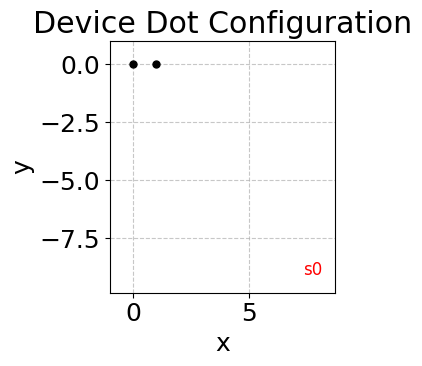

In [8]:
%matplotlib inline
# 19 : 6855079316 , 4269757637 , 0704002487
parms_names = ['device', 'sensors_coordinates']
params = u.load_parameters(3, '2868371462', [3,2,1], parms_names)
u.plot_device_lattice(params['device'], params['sensors_coordinates'])


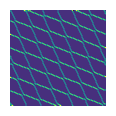

In [2]:
grad = u.load_parameters(1, '0005722789', [3,2,1], ['csd_gradient'])

csd = u.load_parameters(1, '0005722789', [3,2,1], ['csd'])


%matplotlib inline
fig, ax = plt.subplots(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
ax.pcolormesh(grad['csd_gradient'].squeeze())
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# mu.show_image_from_tensor(csd['csd'])


Loading batches: 1 from ./ALICE/N-2_S-1\96x96\batch-1\datapoints.h5
Original dataset size: 1000
Filtered dataset size: 998
Removed 2 datapoints
Preprocessing data...
Data preprocessed.
Loading batches: 1 from ./ALICE/N-2_S-1\96x96\batch-1\datapoints.h5
Original dataset size: 1000
Filtered dataset size: 998
Removed 2 datapoints
Preprocessing data...
Data preprocessed.


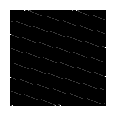

In [3]:
config_tuple = (3,2,1)
X, y = mu.prepare_data(config_tuple, all_batches=False, batches=np.arange(1,2), param_names=['csd_gradient', 'C_DD', 'C_DG'])
X_1, y_1 = mu.prepare_data(config_tuple, all_batches=False, batches=np.arange(1,2), param_names=['csd', 'C_DD', 'C_DG'])
%matplotlib inline
mu.show_image_from_tensor(X[0])

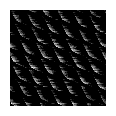

In [4]:
mu.show_image_from_tensor(X_1[0])

### Data preprocessing

In [10]:
# datapoints = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'])
datapoints_gradient = mu.load_datapoints((3,2,1),param_names=['csd','csd_gradient', 'C_DD', 'C_DG'], all_batches=False, batches=np.arange(2,3))
datapoints = mu.load_datapoints((2,2,0),param_names=['csd', 'C_DD', 'C_DG'], all_batches=False, batches=np.arange(2,3))

print(f"The amount of datapoints loaded: {len(datapoints)}.")
print(f"The shape of CSD {datapoints[0][0].shape}, and its type {type(datapoints[0][0])}.")

print(f"The amount of datapoints loaded: {len(datapoints_gradient)}.")
print(f"The shape of CSD gradient {datapoints_gradient[0][0].shape}, and its type {type(datapoints_gradient[0][0])}.")


Loading batches: 1 from ./datasets/N-2_S-1\96x96\batch-2\datapoints.h5
Loading batches: 1 from ./datasets/K-2\96x96\batch-2\datapoints.h5
The amount of datapoints loaded: 500.
The shape of CSD (4, 96, 96), and its type <class 'numpy.ndarray'>.
The amount of datapoints loaded: 50.
The shape of CSD gradient (4, 96, 96), and its type <class 'numpy.ndarray'>.


#### Reconstructed image from saved np.ndarray

In [11]:
example = datapoints[19] # 67, 19
example_gradient = datapoints_gradient[19] # 67, 19

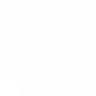

In [12]:
example_csd = example[0]
example_csd_noisy = example_gradient[0]
example_csd_gradient = example_gradient[1]

example_csd.shape
%matplotlib inline
u.reconstruct_img_from_tensor(example_csd)

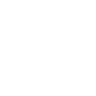

In [13]:
%matplotlib inline
u.reconstruct_img_from_tensor(example_csd_noisy)

In [14]:
u.reconstruct_img_from_tensor(example_csd_gradient)

TypeError: Cannot handle this data type: (1, 1, 1), |u1

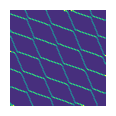

In [10]:
%matplotlib inline
plt.figure(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
plt.pcolormesh(example_csd_gradient[0])
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### The preprocessed input seen by the model

In [6]:
%matplotlib inline

tensor = mu.preprocess_csd(example_csd)
mu.show_image_from_tensor(tensor)

TypeError: CSD image must be of a shape 4x96x96

#### Output preproccess

In [ ]:
c_dd, c_dg = example[1], example[2]
print(f"C_DD: \n {c_dd}\n")
print(f"C_DG: \n {c_dg}")

In [ ]:
# output -> a vector -> row by row first from C_DD, then C_DG -> K*(K+1)/2 + K^2 (elements)
#   
output = mu.preprocess_capacitance_matrices(c_dd, c_dg)
assert len(output) == c.K*(c.K+1)//2 + c.K**2

print(output) 

#### Filter dataset

In [ ]:
unfiltered_datapoints = datapoints.copy()
filtred_datapoints = mu.filter_dataset(datapoints)

print(f"Before filtration: {len(unfiltered_datapoints)}.\nAfter filtration: {len(filtred_datapoints)} ({100*len(filtred_datapoints)/len(unfiltered_datapoints):.2f}%).")
# datapoints = filtred_datapoints

#### Train model

### Unit tests

In [15]:
c_dd, c_dg = u.generate_capacitance_matrices()
output = mu.preprocess_capacitance_matrices(c_dd, c_dg)
c_dd_rec, c_dg_rec = mu.reconstruct_capacitance_matrices(output)

assert (c_dd == c_dd_rec).all() and (c_dg == c_dg_rec).all()

In [16]:
# output -> a vector -> row by row first from C_DD, then C_DG -> K*(K+1)/2 + K^2 (elements)outputmupepocess_cpacitance_matricesc_ddc_dg
# c_m = 0.5
# c_dd = np.array([[3.1, 0.5], [0.5, 2.9]])
# np.sum(c_dg, axis=1).T*np.eye(c.K)+c_m

c_dd, c_dg = u.generate_capacitance_matrices()
c_m =  c_dd[0,1]

c_dd_test = np.array([[c_dg[0,0]+c_dg[0,1]+c_m, c_m], [c_m, c_dg[1,0]+c_dg[1,1]+c_m]])

if c.K == 2:
    assert (c_dd == c_dd_test).all()
    assert c_dd[0,1] == c_dd[1,0]

### XAI

In [ ]:
test = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'], all_batches=False, batches=np.arange(41,42))
u.reconstruct_img_from_tensor(test[0][0])

In [ ]:
example_X, example_Y = mu.prepare_data(datasize_cut=1, 
                                       param_names=['csd', 'C_DD', 'C_DG'], 
                                       all_batches=False, batches=np.arange(41,42))

print(example_X.shape, example_Y.shape)
print(example_Y[-1])


In [ ]:
saliency_overlay, gradcam_overlay, prediction, reconstructed_matrices= mu.explain_output(
    input_tensor=example_X,
    model_name='resnet',
    model_path='./Results/resnet18/resnet18_model_20241028_104258/resnet18_model.pth')

print(prediction)
print(reconstructed_matrices)

In [ ]:
np.abs(np.array(example_Y) -  prediction)

In [ ]:
saliency_overlay

In [ ]:
gradcam_overlay

In [ ]:
%matplotlib inline
plot, ax = mu.generate_csd_from_prediction(prediction)
plot.show()

### Noise - test

In [2]:
x_vol = np.linspace(-0.01, 0.05, c.RESOLUTION)
y_vol = np.linspace(-0.01, 0.05, c.RESOLUTION)
ks = 0
device = np.array([[1,1],[1,1]])
# device = np.ones((1,2), dtype=int)

S=2
N=len(u.get_dots_indices(device))
K=N+S
config_tuple = (K,N,S)

cut = np.array([[[1,0,0,0,0], [0,1,0,0,0]]])
sensors_angle = [0, 3*np.pi/2]
sensors_radius = [1.5*c.d_DD, 1.5*c.d_DD]

r = u.generate_dataset(x_vol, y_vol, ks, device, 
                       config_tuple,
                       sensors_angle=sensors_angle, 
                       sensors_radius=sensors_radius, 
                       all_euclidean_cuts=True)

C_DD, C_DG, ks, cut, x, y, csd, poly, sensor, device, sensors = r

Generating dataset for (6, 4, 2) configuration
EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[ 19.1071   1.3833   1.5655   0.8219   0.7522   0.8298]
 [  1.3833  15.4419   0.8067   1.1483   2.1274   0.489 ]
 [  1.5655   0.8067  19.0289   1.2995   0.5016   2.6561]
 [  0.8219   1.1483   1.2995  16.3704   0.9889   1.091 ]
 [  0.7522   2.1274   0.5016   0.9889 100.       0.3308]
 [  0.8298   0.489    2.6561   1.091    0.3308 100.    ]]
                Dot-gate capacitances: 
                [[5.8909 0.9222 1.0437 0.4632 0.     0.    ]
 [0.9222 3.4323 0.4547 0.7655 0.     0.    ]
 [1.0437 0.4547 4.8238 0.8663 0.     0.    ]
 [0.4632 0.7655 0.8663 5.1814 0.     0.    ]
 [0.     0.     0.     0.     3.4686 0.    ]
 [0.     0.     0.     0.     0.     4.2892]]
                Size of Coulomb peaks V[n] is constant
                

            Sensor model deployed

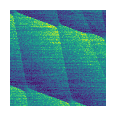

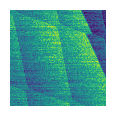

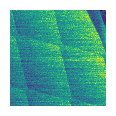

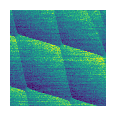

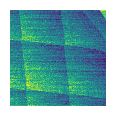

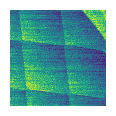

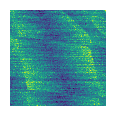

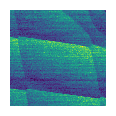

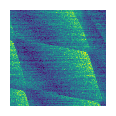

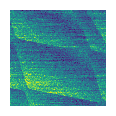

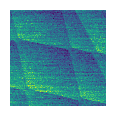

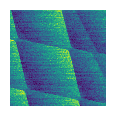

In [4]:
%matplotlib inline
figs_and_ax = u.plot_CSD(x, y, sensor, poly) 

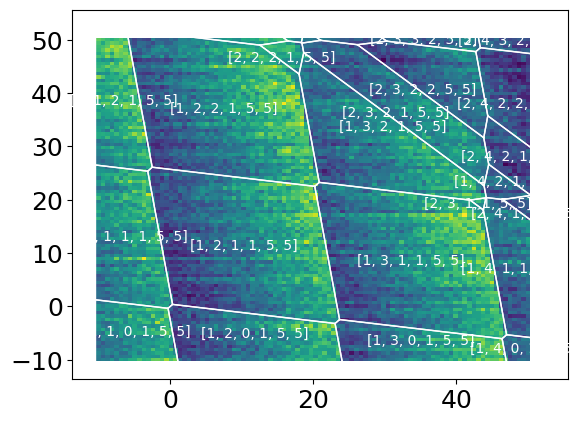

In [5]:
plt.figure()
ax = plt.gca()
        
ax.pcolormesh(1e3*x, 1e3*y, sensor[0,:,:,0].squeeze())

plot_polytopes(ax, poly[0], axes_rescale=1e3, 
                            only_edges=False, only_labels=False)

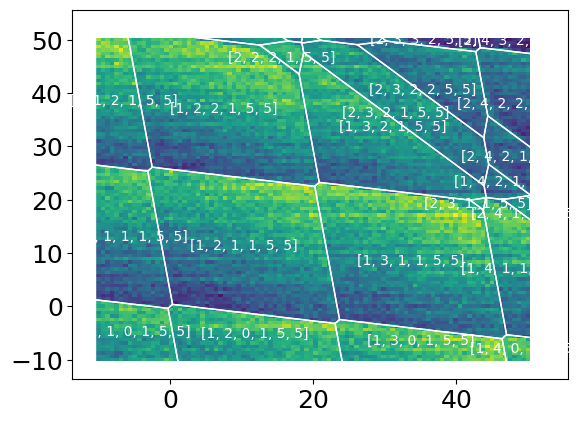

In [6]:
plt.figure()
ax = plt.gca()
        
ax.pcolormesh(1e3*x, 1e3*y, sensor[0,:,:,1].squeeze())

plot_polytopes(ax, poly[0], axes_rescale=1e3, 
                            only_edges=False, only_labels=False)

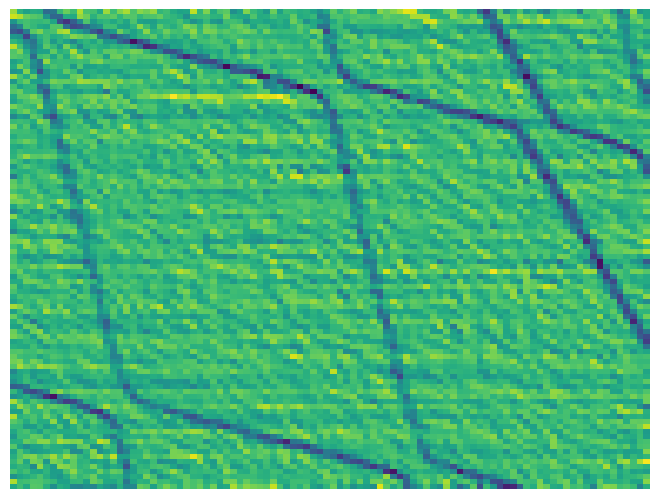

In [5]:
grad = np.gradient(sensor[0,:,:,0], axis=0)+np.gradient(sensor[0,:,:,0], axis=1) + np.gradient(sensor[0,:,:,1], axis=0) + np.gradient(sensor[0,:,:,1], axis=1)


plt.pcolormesh(grad)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

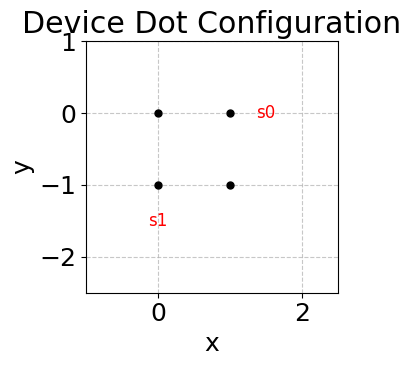

In [6]:
fig, ax = u.plot_device_lattice(device, sensors)

In [14]:
assert np.all(np.sum([np.gradient(sensor, axis=i) for i in [0,1]], axis=0) == np.gradient(sensor,axis=0) + np.gradient(sensor,axis=1))

In [6]:
%matplotlib inline
plt.figure(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
# csd_grad =
plt.pcolormesh( np.gradient(sensor,axis=0) + np.gradient(sensor,axis=1))
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
print(csd_grad.shape)

csd_grad_toech = torch.from_numpy(csd_grad).permute(2, 0, 1).float() / 255.0

SyntaxError: invalid syntax (2561031521.py, line 3)

In [93]:
len(np.array([ [[1,2],[1,2]], [[1,9],[6,9]] ]).shape)

3

### Device

In [18]:
# device = np.array([[0,1, 0,1,0],[1,0,1,0,1],[0,1,0,1,0]])
# device = np.ones((2,2))
# device = np.ones((1,3))
# device = np.array([[1,1,0,0,1]])

# r0 = [c.d_DD*np.sqrt(0.5**2+3**2)]
# t0 = [np.arctan(3/0.5)]
r0 = [6*c.d_DD]
t0 = [0]
S = len(t0)
N = len(u.get_dots_indices(device))
K = N+S

sensors = u.set_sensors_positions(S, device, list_r0=r0, list_theta0=t0)
# sensors = u.set_sensors_positions(S=10, device=device)

print(device, sensors)

[[1 1 0 0 1]] [(600, 0)]


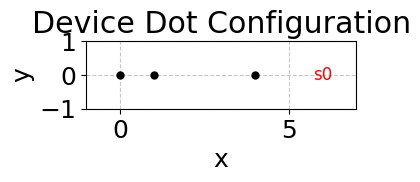

In [19]:
# Example usage:
%matplotlib inline
fig, ax = u.plot_device_lattice(device, sensors)
plt.show()

In [11]:
path = 'Results/resnet10/resnet10_model_20241203_104554/predictions.h5'
config_tuple = (3,2,1)

def print_structure_h5_file(name, obj):
    """Helper function to print HDF5 file structure"""
    print(name)
    if isinstance(obj, h5py.Dataset):
        print(f"    Shape: {obj.shape}")
        print(f"    Type: {obj.dtype}")


with h5py.File(path, 'r') as f:
    f.visititems(print_structure_h5_file)
    inputs = f['inputs'][()][:2]
    outputs = f['outputs'][()][:2]
    targets = f['targets'][()][:2]



vals = []
l2_vals = []
for output, target in zip(outputs, targets):
    vals.append((output, target, mu.physics_informed_regularization(config_tuple, output, target), np.linalg.norm(output-target)))

for output, target in zip(outputs, targets):
    l2_vals.append(np.linalg.norm(output-target))

for v in vals:
    print(v)

# print(f"L2 norm values: mean={np.mean(l2_vals)}, min={min(l2_vals)}, max={max(l2_vals)}")

# mean_vals = np.mean([x[2] for x in vals])
# min_vals = min(vals, key=lambda x: x[-1])
# max_vals = max(vals, key=lambda x: x[-1])

# print(f"PI reg.: mean={mean_vals},\n min={min_vals} ({np.linalg.norm(min_vals[0]-min_vals[1])}),\n max={max_vals} ({np.linalg.norm(max_vals[0]-max_vals[1])})")


inputs
    Shape: (10000, 1, 96, 96)
    Type: float32
outputs
    Shape: (10000, 15)
    Type: float32
targets
    Shape: (10000, 15)
    Type: float32
(array([2.3036381e+01, 4.6295619e+00, 2.6039811e-02, 2.1029575e+01,
       1.3832517e-02, 1.5328026e+01, 7.5555553e+00, 2.1548426e+00,
       2.5120797e-03, 2.1548619e+00, 8.0061226e+00, 1.9179435e-03,
       2.0699285e-03, 4.6665827e-03, 7.6808863e+00], dtype=float32), array([2.38487e+01, 4.76650e+00, 1.13000e-02, 2.05665e+01, 7.20000e-03,
       2.20747e+01, 7.46400e+00, 2.19990e+00, 0.00000e+00, 2.19990e+00,
       7.87660e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.06074e+01],
      dtype=float32), 15.612511496046595, 7.416512)
(array([6.0400963e+01, 1.4342017e+01, 6.1852127e-02, 6.7824623e+01,
       2.8620267e-02, 4.3115639e+01, 1.8118141e+01, 6.7006359e+00,
       1.5409231e-02, 6.6991992e+00, 2.2903978e+01, 1.9646420e-03,
       4.5102262e-03, 6.0284231e-03, 2.2083418e+01], dtype=float32), array([6.35879e+01, 1.64815e+01, 2.3

In [12]:
outputs = torch.tensor(outputs)
targets = torch.tensor(targets)

mu.physics_informed_regularization_torch(config_tuple, outputs, targets)

tensor([464.1948,  61.8283])